# Full MARS demo

This is the tutorial from the readme of MARS_Developer in Jupyter notebook form.

## 1. 📁 Create a new MARS Training Project

Your MARS project directory will contain all the files created during the process of training MARS detector and pose models on your data.

In addition to creating a project directory, `create_new_project` takes two optional arguments:
* Set `download_MARS_checkpoints=True` to download pre-trained MARS detection and pose models. If your dataset looks similar to MARS, initializing training from the pre-trained models should help decrease your training data requirements.
* Set `download_demo_data=True` to download a sample dataset, consisting of 2000 frames from videos in the [CRIM13 dataset](https://data.caltech.edu/records/1892), with accompanying manual annotations of animal pose collected via Amazon SageMaker. The sample dataset can also be previewed [here](https://drive.google.com/drive/u/0/folders/1J73k-RC1CyJQOjUdWr-75P3w_mfpRvXr).

In [1]:
from create_new_project import *

location = 'D:'
name = 'my_project'

create_new_project(location, name,
                   download_MARS_checkpoints=False,
                   download_demo_data=False)

I couldn't find the location D:


Within your project folder is a file called `project_config.yaml`. This file contains many important features: keypoint and animal names, instructions for your annotation job, and names/data assignments for detection and pose models. Open this file in a text editor and fill in the fields as instructed in the comments.

## 2. ✍️ Collect a set of manually annotated animal poses
In this step, we will get some training data for our detector and pose estimator.

> If you set `download_demo_data=True` in step 1, **skip to step 2.3** to format your data for training.

> If you've already annotated some poses in DeepLabCut, copy the annotation csv to `my_project/annotation_data`, and the images you annotated to `my_project/annotation_data/raw_images`. Set `manifest_name` in `project_config.yaml` to the name of your csv.
>
> Then **skip to step 2.3** to format your data for training.

### 2.1 Extract video frames that you would like to annotate
First, we need to collect a set of video frames to annotate for animal pose. Copy these videos into `my_project/annotation_data/behavior_movies`.

Now, we'll use `extract_frames_to_label` to sample frames from these movies. It takes as input a project path, plus two optional arguments:
* `n_frames` the number of frames to sample for labeling (default is 1000)
* `to_skip` omits the first X frames from each video during sampling (default is 0)

If you already have frames on hand but haven't annotated them, copy those images to `my_project/annotation_data/raw_images` so they can be accessed during the labelling job and later during model training.



In [2]:
from pose_annotation_tools.extract_frames_to_label import *

project_path = 'D:\my_project'
extract_frames_to_label(project_path, n_frames=5)

Couldn't find a project at D:\my_project


You should now have a folder `my_project/annotation_data/raw_images` of video frames.

### 2.2 Run a labeling job
Refer to [these instructions](https://github.com/neuroethology/MARS_Developer/blob/master/pose_annotation_tools/docs/readme_groundTruthSetup.md) to run a labeling job on Amazon SageMaker.

This job will produce a file called `output.manifest` which you should add to `my_project/annotation_data`. If you change the name of this manifest file, be sure to update the `manifest_name` field of `my_project/project_config.yaml` appropriately.

### 2.3 Post-process the manual pose annotations
This script carries out several steps to create "ground truth" keypoint locations by taking the median across AWS workers, correct for left/right flips of body part labels, and package your data for model-training. The processed annotation data will be added as a new file to `annotation_data`.

In [1]:
from pose_annotation_tools.annotation_postprocessing import *

project_path = '/media/storage/sebastian/michael_data/tracking_example/'
annotation_postprocessing(project_path)

Instructions for updating:
non-resource variables are not supported in the long term
Processing manifest file...
1984
Detecting bad workers
  frame 1000
Ground-truth keypoint locations extracted!
Generating black_top detection training files...
done.
Generating white_top detection training files...
done.
Generating top pose training files...
done.
Generating black_top priors...
done.
Generating white_top priors...
done.


### 2.4 Visualize some manual pose annotations

We'll next take a look at the inter-annotator variability in your pose labels, as this is a good predictor for how well MARS will perform. (If you annotated pose yourself you can skip this step.)

To look at annotations on an example frame, call `plot_frame`. It takes as input a project path and a number (specifying the image in your annotation dataset.) It also takes two optional plotting arguments:
* `markersize` the size of the keypoint makers (default is 8)
* `figsize` the width and height of the plot (default is [15,20])

The colored points are the raw annotation data. Points are colored by body part, and all points of a given marker shape come from the same worker. The black and white points are the medians across annotators. These medians are the "ground truth" that we'll use to train MARS.

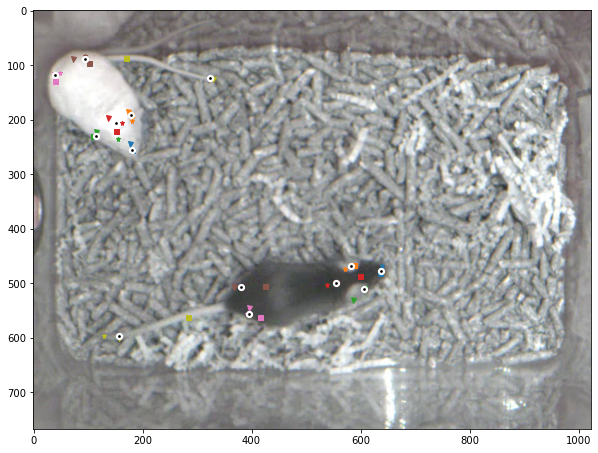

In [6]:
from pose_annotation_tools.evaluation import *

# project_path = 'D:\my_project'
frame_num = 918  # the frame number to look at in your data

plot_frame(project_path,frame_num, markersize=5, figsize=[10,10])

To summarize worker performance, we'll look at the **Percent Correct Keypoints (PCK)**. This is the percentage of keypoints from individual workers that fall within a radius X of the "ground truth" worker median.

For each keypoint, we compute the distance from each worker's annotation to the median of the remaining workers, on each frame. We then plot cdfs of **median** (dashed line) worker-to-median distances for each frame, as well as a shaded area whose upper and lower bounds are the min and max worker-to-median distances, respectively.

The "all" plot takes the framewise average across keypoints, for each metric.

`plot_human_PCK` summarizes worker performance for your dataset. It takes four optional arguments:
* `animal_names` specifies which animals to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools data across animal types in your dataset.

/home/sebastianmap07/miniconda3/envs/mars_dev/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sebastianmap07/MARS_Developer/pose_annotation_tools/evaluation.py:107: RuntimeWarning: Mean of empty slice
  dMean[:, fr] = np.nanmean(trial_dists, axis=0)


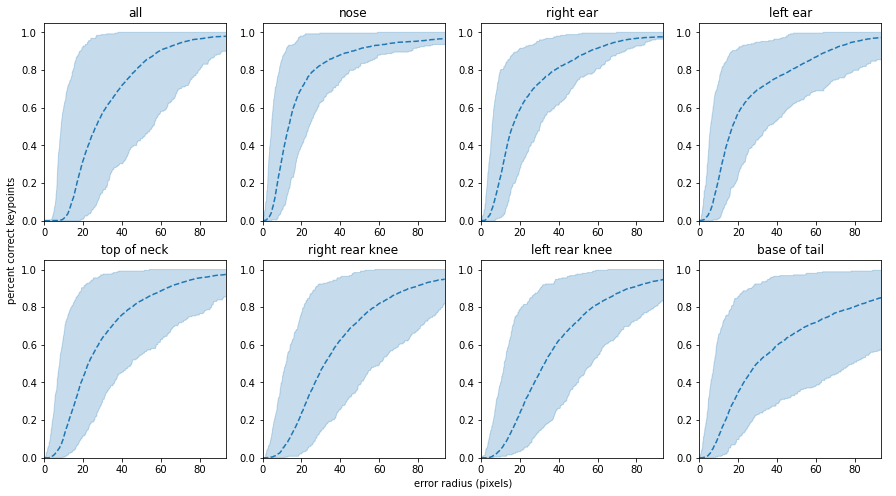

In [2]:
from pose_annotation_tools.evaluation import *

# project_path = 'D:\my_project'
project_path = '/media/storage/sebastian/michael_data/tracking_example/'
plot_human_PCK(project_path, combine_animals=True, pixel_units=True)

## 3. 🎯 Fine-tune the MARS detector to your data


### 3.1 Run the training code
`run_training` takes two optional arguments:
* `models` takes names of detectors to train, in case you only want to work on one detector at a time (MARS trains all detectors sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml` (300,000 by default). You can set this to a small number to confirm everything is working before launching your full training job.

If training is interrupted, it will resume from the most recent model checkpoint; MARS saves checkpoints every 30 minutes (adjust this in `my_project/detection/train_config.yaml`), and when training completes.

In [4]:
from multibox_detection import train_detect

project_path = '/media/storage/sebastian/michael_data/tracking_example/'
train_detect.run_training(project_path, max_training_steps=550000)

/home/sebastianmap07/MARS_Developer/multibox_detection/train_detect.py:391: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bbox_priors = np.array(bbox_priors).astype(np.float32)


INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/detection/black_top_log/model.ckpt-760455
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /media/storage/sebastian/michael_data/tracking_example/detection/black_top_log/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:Recording summary at step 760455.
INFO:tensorflow:Recording summary at step 760455.
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.


/home/sebastianmap07/miniconda3/envs/mars_dev/lib/python3.7/site-packages/tensorflow_core/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "
/home/sebastianmap07/MARS_Developer/multibox_detection/train_detect.py:391: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bbox_priors = np.array(bbox_priors).astype(np.float32)


INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/detection/white_top_log/model.ckpt-424963
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /media/storage/sebastian/michael_data/tracking_example/detection/white_top_log/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:Recording summary at step 424963.
INFO:tensorflow:Recording summary at step 424963.
INFO:tensorflow:global step 424999: loss = 28.8542 (0.135 sec/step)
INFO:tensorflow:Recording summary at step 425052.
INFO:tensorflow:global step 425099: loss = 15.5223 (0.139 sec/step)
INFO:tensorflow:global step 425199: loss = 22.2403 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 425265.
INFO:tensorflow:global step 425299: loss = 35.4192 (0.148 sec/step)
INFO:tensorflow:global step 425399: loss = 16.2060 (0.140 sec/step)
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 432880.
INFO:tensorflow:global step 432899: loss = 40.7319 (0.137 sec/step)
>> global step 8000:    train=4.35653018951416   validation=[1.973585]
INFO:tensorflow:global step 432999: loss = 12.9120 (0.138 sec/step)
INFO:tensorflow:Recording summary at step 433093.
INFO:tensorflow:global step 433099: loss = 17.1981 (0.142 sec/step)
INFO:tensorflow:global step 433199: loss = 4.2205 (0.138 sec/step)
INFO:tensorflow:global step 433299: loss = 26.4498 (0.138 sec/step)
INFO:tensorflow:Recording summary at step 433307.
INFO:tensorflow:global step 433399: loss = 19.3150 (0.132 sec/step)
INFO:tensorflow:global step 433499: loss = 4.9959 (0.135 sec/step)
INFO:tensorflow:Recording summary at step 433521.
INFO:tensorflow:global step 433599: loss = 26.8846 (0.144 sec/step)
INFO:tensorflow:global step 433699: loss = 4.1947 (0.139 sec/step)
INFO:tensorflow:Recording summary at step 433734.
INFO:tensorflow:global step 433799: loss = 27.1774 (0.125 sec/step)
IN

INFO:tensorflow:global step 441199: loss = 41.2589 (0.137 sec/step)
INFO:tensorflow:Recording summary at step 441223.
INFO:tensorflow:global step 441299: loss = 11.1902 (0.148 sec/step)
INFO:tensorflow:global step 441399: loss = 15.5573 (0.141 sec/step)
INFO:tensorflow:Recording summary at step 441437.
INFO:tensorflow:global step 441499: loss = 7.1839 (0.142 sec/step)
INFO:tensorflow:global step 441599: loss = 15.1258 (0.146 sec/step)
INFO:tensorflow:Recording summary at step 441652.
INFO:tensorflow:global step 441699: loss = 12.7397 (0.141 sec/step)
INFO:tensorflow:global step 441799: loss = 4.9097 (0.133 sec/step)
INFO:tensorflow:Recording summary at step 441865.
INFO:tensorflow:global step 441899: loss = 26.8092 (0.145 sec/step)
>> global step 17000:    train=10.3487548828125   validation=[4.7829013]
INFO:tensorflow:global step 441999: loss = 11.6606 (0.135 sec/step)
INFO:tensorflow:Recording summary at step 442078.
INFO:tensorflow:global step 442099: loss = 11.4875 (0.139 sec/step)

INFO:tensorflow:Recording summary at step 449565.
INFO:tensorflow:global step 449599: loss = 31.7334 (0.139 sec/step)
INFO:tensorflow:global step 449699: loss = 10.3730 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 449780.
INFO:tensorflow:global step 449799: loss = 5.7760 (0.138 sec/step)
INFO:tensorflow:global step 449899: loss = 11.7479 (0.139 sec/step)
>> global step 25000:    train=12.797768592834473   validation=[6.3122754]
INFO:tensorflow:Recording summary at step 449993.
INFO:tensorflow:global step 449999: loss = 3.5922 (0.140 sec/step)
INFO:tensorflow:global step 450099: loss = 14.0828 (0.138 sec/step)
INFO:tensorflow:global step 450199: loss = 14.3805 (0.138 sec/step)
INFO:tensorflow:Saving checkpoint to path /media/storage/sebastian/michael_data/tracking_example/detection/white_top_log/model.ckpt
INFO:tensorflow:Recording summary at step 450207.
INFO:tensorflow:global step 450299: loss = 4.6129 (0.142 sec/step)
INFO:tensorflow:global step 450399: loss = 5.6288 (0

INFO:tensorflow:global step 457799: loss = 14.0006 (0.137 sec/step)
INFO:tensorflow:Recording summary at step 457894.
INFO:tensorflow:global step 457899: loss = 13.4700 (0.145 sec/step)
>> global step 33000:    train=22.153060913085938   validation=[7.6098485]
INFO:tensorflow:global step 457999: loss = 17.4407 (0.139 sec/step)
INFO:tensorflow:global step 458099: loss = 45.0835 (0.132 sec/step)
INFO:tensorflow:Recording summary at step 458107.
INFO:tensorflow:global step 458199: loss = 5.2388 (0.129 sec/step)
INFO:tensorflow:global step 458299: loss = 7.1373 (0.137 sec/step)
INFO:tensorflow:Recording summary at step 458321.
INFO:tensorflow:global step 458399: loss = 6.6370 (0.138 sec/step)
INFO:tensorflow:global step 458499: loss = 6.6634 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 458535.
INFO:tensorflow:global step 458599: loss = 15.5572 (0.124 sec/step)
INFO:tensorflow:global step 458699: loss = 4.6796 (0.143 sec/step)
INFO:tensorflow:Recording summary at step 458749.


INFO:tensorflow:global step 466099: loss = 31.6141 (0.139 sec/step)
INFO:tensorflow:global step 466199: loss = 11.4882 (0.146 sec/step)
INFO:tensorflow:Recording summary at step 466239.
INFO:tensorflow:global step 466299: loss = 3.6079 (0.137 sec/step)
INFO:tensorflow:global step 466399: loss = 9.7246 (0.147 sec/step)
INFO:tensorflow:Recording summary at step 466454.
INFO:tensorflow:global step 466499: loss = 4.5566 (0.137 sec/step)
INFO:tensorflow:global step 466599: loss = 20.0793 (0.139 sec/step)
INFO:tensorflow:Recording summary at step 466667.
INFO:tensorflow:global step 466699: loss = 2.6421 (0.141 sec/step)
INFO:tensorflow:global step 466799: loss = 20.0745 (0.128 sec/step)
INFO:tensorflow:Recording summary at step 466883.
INFO:tensorflow:global step 466899: loss = 4.4909 (0.128 sec/step)
>> global step 42000:    train=3.9499144554138184   validation=[0.9556063]
INFO:tensorflow:global step 466999: loss = 14.5494 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 467096.


INFO:tensorflow:global step 474499: loss = 14.6533 (0.142 sec/step)
INFO:tensorflow:Recording summary at step 474584.
INFO:tensorflow:global step 474599: loss = 12.2307 (0.139 sec/step)
INFO:tensorflow:global step 474699: loss = 13.9498 (0.140 sec/step)
INFO:tensorflow:global step 474799: loss = 11.7004 (0.145 sec/step)
INFO:tensorflow:Recording summary at step 474798.
INFO:tensorflow:global step 474899: loss = 4.5196 (0.142 sec/step)
>> global step 50000:    train=2.683176279067993   validation=[1.1118208]
INFO:tensorflow:global step 474999: loss = 4.5428 (0.138 sec/step)
INFO:tensorflow:Recording summary at step 475010.
INFO:tensorflow:global step 475099: loss = 29.0292 (0.136 sec/step)
INFO:tensorflow:global step 475199: loss = 12.2395 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 475225.
INFO:tensorflow:global step 475299: loss = 22.1604 (0.142 sec/step)
INFO:tensorflow:global step 475399: loss = 26.2903 (0.141 sec/step)
INFO:tensorflow:Recording summary at step 475440

INFO:tensorflow:Recording summary at step 482706.
INFO:tensorflow:global step 482799: loss = 14.7123 (0.140 sec/step)
INFO:tensorflow:global step 482899: loss = 6.3947 (0.133 sec/step)
INFO:tensorflow:Recording summary at step 482920.
>> global step 58000:    train=14.852835655212402   validation=[4.6079345]
INFO:tensorflow:global step 482999: loss = 12.2903 (0.135 sec/step)
INFO:tensorflow:global step 483099: loss = 11.3063 (0.143 sec/step)
INFO:tensorflow:Recording summary at step 483132.
INFO:tensorflow:global step 483199: loss = 14.4322 (0.144 sec/step)
INFO:tensorflow:global step 483299: loss = 13.6953 (0.137 sec/step)
INFO:tensorflow:Recording summary at step 483346.
INFO:tensorflow:global step 483399: loss = 18.9229 (0.137 sec/step)
INFO:tensorflow:global step 483499: loss = 3.5068 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 483559.
INFO:tensorflow:global step 483599: loss = 16.5694 (0.134 sec/step)
INFO:tensorflow:global step 483699: loss = 20.6887 (0.127 sec/ste

INFO:tensorflow:Recording summary at step 491041.
INFO:tensorflow:global step 491099: loss = 23.9172 (0.127 sec/step)
INFO:tensorflow:global step 491199: loss = 8.9453 (0.147 sec/step)
INFO:tensorflow:Recording summary at step 491254.
INFO:tensorflow:global step 491299: loss = 29.0161 (0.140 sec/step)
INFO:tensorflow:global step 491399: loss = 5.5213 (0.141 sec/step)
INFO:tensorflow:Recording summary at step 491466.
INFO:tensorflow:global step 491499: loss = 22.7704 (0.132 sec/step)
INFO:tensorflow:global step 491599: loss = 14.1652 (0.137 sec/step)
INFO:tensorflow:Recording summary at step 491680.
INFO:tensorflow:global step 491699: loss = 9.0361 (0.137 sec/step)
INFO:tensorflow:global step 491799: loss = 17.5542 (0.135 sec/step)
INFO:tensorflow:Recording summary at step 491894.
INFO:tensorflow:global step 491899: loss = 16.8208 (0.148 sec/step)
>> global step 67000:    train=3.8195223808288574   validation=[1.8843359]
INFO:tensorflow:global step 491999: loss = 6.2600 (0.141 sec/step)

INFO:tensorflow:global step 499399: loss = 4.2377 (0.129 sec/step)
INFO:tensorflow:global step 499499: loss = 2.8869 (0.146 sec/step)
INFO:tensorflow:Recording summary at step 499595.
INFO:tensorflow:global step 499599: loss = 32.2137 (0.126 sec/step)
INFO:tensorflow:global step 499699: loss = 3.2106 (0.142 sec/step)
INFO:tensorflow:global step 499799: loss = 4.3238 (0.139 sec/step)
INFO:tensorflow:Recording summary at step 499810.
INFO:tensorflow:global step 499899: loss = 4.3520 (0.134 sec/step)
>> global step 75000:    train=12.55526351928711   validation=[1.6806833]
INFO:tensorflow:global step 499999: loss = 14.8062 (0.138 sec/step)
INFO:tensorflow:Recording summary at step 500024.
INFO:tensorflow:global step 500099: loss = 10.2900 (0.138 sec/step)
INFO:tensorflow:global step 500199: loss = 13.6581 (0.139 sec/step)
INFO:tensorflow:Recording summary at step 500238.
INFO:tensorflow:global step 500299: loss = 23.5941 (0.140 sec/step)
INFO:tensorflow:global step 500399: loss = 28.5479 

INFO:tensorflow:global step 507699: loss = 5.6826 (0.142 sec/step)
INFO:tensorflow:Recording summary at step 507710.
INFO:tensorflow:global step 507799: loss = 12.1576 (0.145 sec/step)
INFO:tensorflow:global step 507899: loss = 7.6773 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 507923.
>> global step 83000:    train=16.516878128051758   validation=[6.2313137]
INFO:tensorflow:global step 507999: loss = 9.6400 (0.127 sec/step)
INFO:tensorflow:global step 508099: loss = 22.3450 (0.138 sec/step)
INFO:tensorflow:Recording summary at step 508137.
INFO:tensorflow:global step 508199: loss = 16.3934 (0.137 sec/step)
INFO:tensorflow:global step 508299: loss = 4.0672 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 508351.
INFO:tensorflow:global step 508399: loss = 3.3864 (0.127 sec/step)
INFO:tensorflow:global step 508499: loss = 6.4849 (0.141 sec/step)
INFO:tensorflow:Recording summary at step 508565.
INFO:tensorflow:global step 508599: loss = 5.2484 (0.138 sec/step)
IN

INFO:tensorflow:global step 515999: loss = 29.7774 (0.146 sec/step)
INFO:tensorflow:Recording summary at step 516055.
INFO:tensorflow:global step 516099: loss = 10.6453 (0.145 sec/step)
INFO:tensorflow:global step 516199: loss = 9.8205 (0.139 sec/step)
INFO:tensorflow:Recording summary at step 516268.
INFO:tensorflow:global step 516299: loss = 8.5257 (0.139 sec/step)
INFO:tensorflow:global step 516399: loss = 4.1522 (0.141 sec/step)
INFO:tensorflow:Recording summary at step 516483.
INFO:tensorflow:global step 516499: loss = 9.8108 (0.127 sec/step)
INFO:tensorflow:global step 516599: loss = 11.5043 (0.144 sec/step)
INFO:tensorflow:global step 516699: loss = 12.5027 (0.141 sec/step)
INFO:tensorflow:Recording summary at step 516697.
INFO:tensorflow:global step 516799: loss = 17.4316 (0.138 sec/step)
INFO:tensorflow:global step 516899: loss = 17.1285 (0.144 sec/step)
INFO:tensorflow:Recording summary at step 516911.
>> global step 92000:    train=10.104093551635742   validation=[2.8016036]

INFO:tensorflow:Recording summary at step 524395.
INFO:tensorflow:global step 524399: loss = 11.6754 (0.142 sec/step)
INFO:tensorflow:global step 524499: loss = 9.5941 (0.138 sec/step)
INFO:tensorflow:global step 524599: loss = 8.9059 (0.128 sec/step)
INFO:tensorflow:Recording summary at step 524610.
INFO:tensorflow:global step 524699: loss = 3.4601 (0.149 sec/step)
INFO:tensorflow:global step 524799: loss = 8.3843 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 524823.
INFO:tensorflow:global step 524899: loss = 14.8376 (0.137 sec/step)
>> global step 100000:    train=19.390541076660156   validation=[3.9266622]
INFO:tensorflow:global step 524999: loss = 11.8919 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 525037.
INFO:tensorflow:global step 525099: loss = 13.2721 (0.143 sec/step)
INFO:tensorflow:global step 525199: loss = 7.1177 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 525253.
INFO:tensorflow:global step 525299: loss = 17.5572 (0.143 sec/step)

INFO:tensorflow:global step 532599: loss = 16.9654 (0.137 sec/step)
INFO:tensorflow:global step 532699: loss = 4.2320 (0.137 sec/step)
INFO:tensorflow:Recording summary at step 532713.
INFO:tensorflow:global step 532799: loss = 13.4606 (0.141 sec/step)
INFO:tensorflow:global step 532899: loss = 9.8812 (0.143 sec/step)
INFO:tensorflow:Recording summary at step 532926.
>> global step 108000:    train=4.497234344482422   validation=[1.9511374]
INFO:tensorflow:global step 532999: loss = 25.7498 (0.142 sec/step)
INFO:tensorflow:global step 533099: loss = 5.7149 (0.139 sec/step)
INFO:tensorflow:Recording summary at step 533138.
INFO:tensorflow:global step 533199: loss = 14.2967 (0.127 sec/step)
INFO:tensorflow:global step 533299: loss = 15.7853 (0.133 sec/step)
INFO:tensorflow:Recording summary at step 533352.
INFO:tensorflow:global step 533399: loss = 10.2647 (0.147 sec/step)
INFO:tensorflow:global step 533499: loss = 4.9766 (0.138 sec/step)
INFO:tensorflow:Recording summary at step 533565.

>> global step 116000:    train=9.164167404174805   validation=[2.7146485]
INFO:tensorflow:global step 540999: loss = 4.3652 (0.146 sec/step)
INFO:tensorflow:Recording summary at step 541017.
INFO:tensorflow:global step 541099: loss = 4.5499 (0.137 sec/step)
INFO:tensorflow:global step 541199: loss = 6.4047 (0.147 sec/step)
INFO:tensorflow:Recording summary at step 541230.
INFO:tensorflow:global step 541299: loss = 9.0900 (0.147 sec/step)
INFO:tensorflow:global step 541399: loss = 17.0337 (0.140 sec/step)
INFO:tensorflow:Recording summary at step 541443.
INFO:tensorflow:global step 541499: loss = 10.8933 (0.141 sec/step)
INFO:tensorflow:global step 541599: loss = 5.3009 (0.127 sec/step)
INFO:tensorflow:Recording summary at step 541656.
INFO:tensorflow:global step 541699: loss = 9.7248 (0.130 sec/step)
INFO:tensorflow:global step 541799: loss = 22.5372 (0.144 sec/step)
INFO:tensorflow:Recording summary at step 541870.
INFO:tensorflow:global step 541899: loss = 27.5828 (0.144 sec/step)
>

INFO:tensorflow:global step 549299: loss = 4.1828 (0.139 sec/step)
INFO:tensorflow:Recording summary at step 549329.
INFO:tensorflow:global step 549399: loss = 23.6653 (0.143 sec/step)
INFO:tensorflow:global step 549499: loss = 7.1821 (0.144 sec/step)
INFO:tensorflow:Recording summary at step 549541.
INFO:tensorflow:global step 549599: loss = 5.9016 (0.142 sec/step)
INFO:tensorflow:global step 549699: loss = 4.9793 (0.137 sec/step)
INFO:tensorflow:Recording summary at step 549754.
INFO:tensorflow:global step 549799: loss = 35.0396 (0.140 sec/step)
INFO:tensorflow:global step 549899: loss = 13.3219 (0.143 sec/step)
>> global step 125000:    train=3.40801739692688   validation=[2.99492]
INFO:tensorflow:Recording summary at step 549967.
INFO:tensorflow:global step 549999: loss = 3.7547 (0.138 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.


/home/sebastianmap07/miniconda3/envs/mars_dev/lib/python3.7/site-packages/tensorflow_core/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


### 3.2 Visualize model performance and pick the best checkpoint
During training, we saved a model checkpoint every 30 minutes (by default). By testing model performance on a small held-out validation set, we can determine which checkpoint performs best, avoiding overfitting to the training set.

To see how far training has progressed, and whether performance might improve with more time, you can plot the validation loss (roughly, the error on the held-out validation set) with `plot_training_progress`. It takes four optional arguments:
* `detector_names` names of pose models to evaluate, as above.
* `figsize` width and height of the plot.
* `omitFirst` omits the first N training steps from plotting.
* `logTime` applies a log-scale to the x axis.

If the validation loss does not seem to have plateaued, your model performance may still improve with more training! Setting `logTime=True` and increasing the value of `omitFirst` can make it easier to see whether performance has plateaued.

In addition, we'll call `save_best_checkpoint` to identify the checkpoint with the greatest validation set performance, and extract it to a separate directory to be used for testing. It takes the optional argument:
* `detector_names` names of detection models to evaluate.

Even if performance hasn't plateaued, you can still proceed to **step 3.3** to evaluate the model on your test set. If you run additional training, be sure to call `save_best_checkpoint` again afterwards so your new best-performing checkpoint is used during testing.

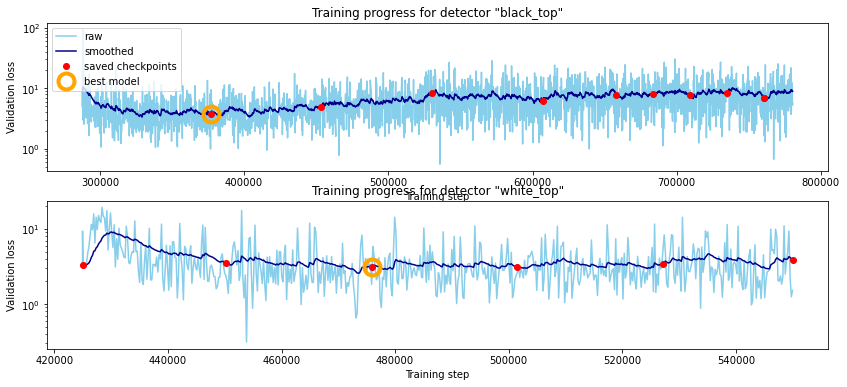

Saved best-performing checkpoint for model "black_top."
Saved best-performing checkpoint for model "white_top."


In [5]:
from multibox_detection import evaluate_detection

# project_path = 'D:\my_project'
evaluate_detection.plot_training_progress(project_path, omitFirst=1000, logTime=False)
evaluate_detection.save_best_checkpoint(project_path)

### 3.3 Evaluate model performance on a held-out test set

After picking the checkpoint that performs best on your validation set, we can evaluate that model's performance on the test set:


First, we'll run our selected model on the test set. `run_test` takes optional arguments:
* `detector_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [6]:
from multibox_detection import evaluate_detection

# project_path = 'D:\my_project'
performance = evaluate_detection.run_test(project_path)

detecting using black_top


/home/sebastianmap07/MARS_Developer/multibox_detection/evaluate_detection.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bbox_priors = np.array(bbox_priors).astype(np.float32)


/media/storage/sebastian/michael_data/tracking_example/detection/black_top_model
is now:/media/storage/sebastian/michael_data/tracking_example/detection/black_top_model/model.ckpt-376879
INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/detection/black_top_model/model.ckpt-376879
Found model for global step: 376879
detecting using white_top
/media/storage/sebastian/michael_data/tracking_example/detection/white_top_model
is now:/media/storage/sebastian/michael_data/tracking_example/detection/white_top_model/model.ckpt-475868
INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/detection/white_top_model/model.ckpt-475868
Found model for global step: 475868


First, let's look at ground truth and predicted bounding boxes for a sample frame. The `Multibox Detection` model makes multiple object detection predictions, each with an associated confidence value.

MARS keeps only the box with the highest confidence score, however when plotting we also show all predicted bounding boxes with a confidence of 0.75 or higher. To change this threshold, modify the optional `confidence_thr` argument to be some value between 0 (lowest) and 1 (highest).

Sample frame for black_top detector:
restoring 199 files from ['/media/storage/sebastian/michael_data/tracking_example/detection/black_top_tfrecords_detection/test_dataset-00000-of-00001']


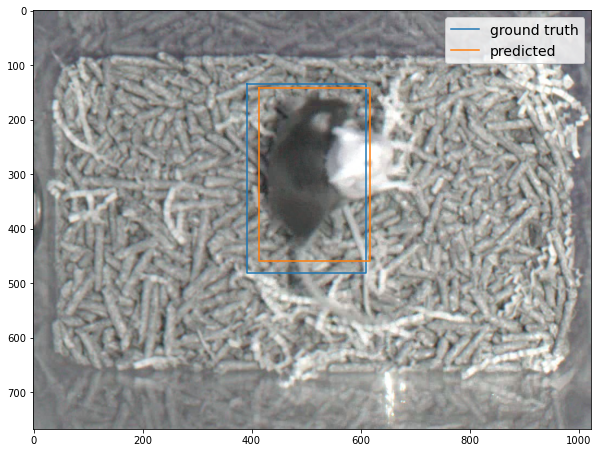

Sample frame for white_top detector:
restoring 199 files from ['/media/storage/sebastian/michael_data/tracking_example/detection/white_top_tfrecords_detection/test_dataset-00000-of-00001']


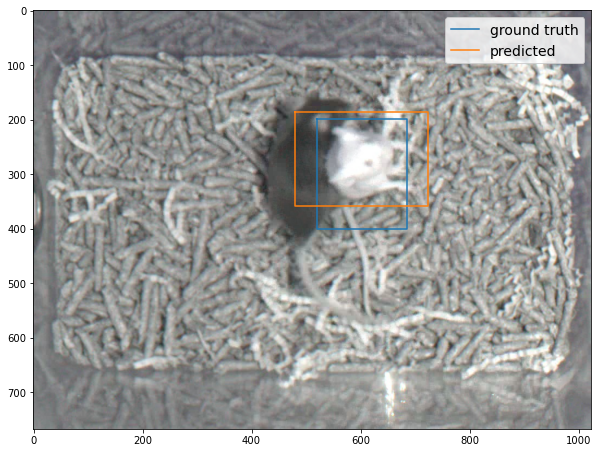

In [7]:
from multibox_detection import evaluate_detection

# project_path = 'D:\my_project'
frame_num = 11

evaluate_detection.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10], confidence_thr=0.75)

Now let's get some summary statistics using the COCO API. The most common metric for evaluating detector performance is the **Intesection over Union (IoU)** - the ratio of the area of overlap between ground truth and predicted boxes, divided by the union of their areas- ie $(\textrm{ground truth} \cap \textrm{predicted})/(\textrm{ground truth} \cup \textrm{predicted})$.

We'll report the **mean Average Precision** and **mean Average Recall** (mAP and mAR) of the IoU, which are the average of Precision and Recall values computed over a range of thresholds on IoU values. This is a standard method for evaluating object detector performance; see the MARS manuscript for an explanation of this metric, or [this article](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3) for further reading.

In [8]:
performance = evaluate_detection.coco_eval(project_path)

for model in performance.keys():
    print('Performance for ' + model + ':')
    performance[model].summarize()

Performance for black_top:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.638
Performance for white_top:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.672


Finally, we'll plot **PR Curves**, showing the Precision vs Recall of our detector for various confidence thresholds. Line color here indicates the minimum IoU required to be counted as a correct detection.

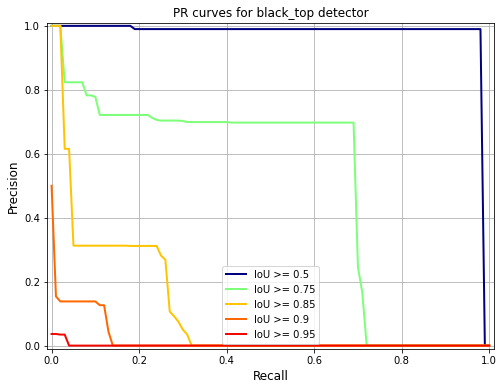

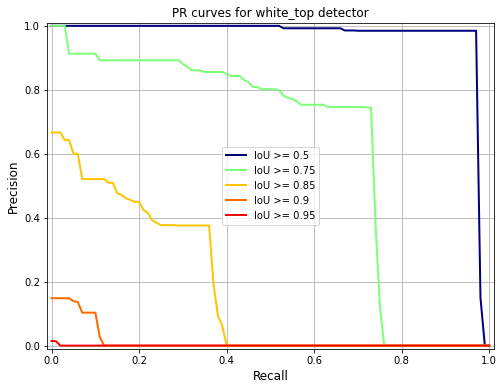

In [9]:
from multibox_detection import evaluate_detection

# project_path = 'D:\my_project'
evaluate_detection.pr_curve(project_path)

### 3.4 (Optional) test your detector on new videos

💡 If you are working with top-view mouse videos, it is possible that MARS's pose estimator will work for you out of the box now that you have a working detector. Skip to step 5 to try it out! If you're not happy with the performance, continue to step 4 where you'll be able to fine-tune the pose estimator.

## 4. 🐁 Fine-tune the MARS pose estimator to your data


### 4.1 Run the training code
Training the pose estimator is the same as training your detectors.

`run_training` again takes two optional arguments:
* `pose_model_names` takes names of pose models to train, in case you only want to work on one model at a time (MARS trains all models sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml`. You can set this to a small number to confirm everything is working before launching your full training job.

In [2]:
from hourglass_pose import train_pose

# project_path = 'D:\my_project'
project_path = '/media/storage/sebastian/michael_data/tracking_example/'
train_pose.run_training(project_path, max_training_steps=700000)





INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/pose/top_log/model.ckpt-539952
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /media/storage/sebastian/michael_data/tracking_example/pose/top_log/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 539955.
INFO:tensorflow:Recording summary at step 539955.
INFO:tensorflow:Recording summary at step 539956.
INFO:tensorflow:global_step/sec: 0.0843497
INFO:tensorflow:global step 539999: loss = 3092.1165 (0.431 sec/step)
INFO:tensorflow:Recording summary at step 540006.
INFO:tensorflow:global_step/sec: 2.50756
INFO:tensorflow:Recording summary at step 540092.
INFO:tensorflow:global step 540099: loss = 3140.2263 (0.328 sec/step)
INFO:tensorflow:global_step/sec: 2.90091
INFO:tensorf

INFO:tensorflow:Recording summary at step 545600.
INFO:tensorflow:Recording summary at step 545685.
INFO:tensorflow:global step 545699: loss = 3953.4751 (0.356 sec/step)
INFO:tensorflow:Recording summary at step 545769.
INFO:tensorflow:global step 545799: loss = 2744.8335 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 545854.
INFO:tensorflow:global step 545899: loss = 2287.5146 (0.328 sec/step)
INFO:tensorflow:Recording summary at step 545938.
INFO:tensorflow:global step 545999: loss = 2939.8789 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 546023.
INFO:tensorflow:global step 546099: loss = 2939.6833 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 546107.
INFO:tensorflow:Recording summary at step 546193.
INFO:tensorflow:global step 546199: loss = 2782.0728 (0.336 sec/step)
INFO:tensorflow:Recording summary at step 546277.
INFO:tensorflow:global step 546299: loss = 2951.7957 (0.363 sec/step)
INFO:tensorflow:Recording summary at step 546362.
INFO:tenso

INFO:tensorflow:global step 551899: loss = 2103.6060 (0.344 sec/step)
INFO:tensorflow:Recording summary at step 551947.
INFO:tensorflow:global step 551999: loss = 2674.8167 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 552032.
INFO:tensorflow:global step 552099: loss = 2578.7305 (0.357 sec/step)
INFO:tensorflow:Recording summary at step 552117.
INFO:tensorflow:global step 552199: loss = 2362.4070 (0.362 sec/step)
INFO:tensorflow:Recording summary at step 552201.
INFO:tensorflow:Recording summary at step 552286.
INFO:tensorflow:global step 552299: loss = 3045.2417 (0.327 sec/step)
INFO:tensorflow:Recording summary at step 552370.
INFO:tensorflow:global step 552399: loss = 3059.9973 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 552455.
INFO:tensorflow:global step 552499: loss = 2948.7185 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 552540.
INFO:tensorflow:global step 552599: loss = 2914.2261 (0.355 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:global step 558199: loss = 3041.8333 (0.350 sec/step)
INFO:tensorflow:Recording summary at step 558208.
INFO:tensorflow:Recording summary at step 558291.
INFO:tensorflow:global step 558299: loss = 3894.0664 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 558376.
INFO:tensorflow:global step 558399: loss = 3050.7097 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 558461.
INFO:tensorflow:global step 558499: loss = 2809.4949 (0.362 sec/step)
INFO:tensorflow:Recording summary at step 558546.
INFO:tensorflow:global step 558599: loss = 3418.8792 (0.361 sec/step)
INFO:tensorflow:Recording summary at step 558631.
INFO:tensorflow:global step 558699: loss = 2541.3167 (0.349 sec/step)
INFO:tensorflow:Recording summary at step 558715.
INFO:tensorflow:global step 558799: loss = 2898.6045 (0.360 sec/step)
INFO:tensorflow:Recording summary at step 558800.
INFO:tensorflow:Recording summary at step 558885.
INFO:tensorflow:global step 558899: loss = 2655.1538 (0.339 

INFO:tensorflow:Recording summary at step 564563.
INFO:tensorflow:global step 564599: loss = 2879.5251 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 564649.
INFO:tensorflow:global step 564699: loss = 3081.4324 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 564734.
INFO:tensorflow:global step 564799: loss = 3008.6233 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 564819.
INFO:tensorflow:global step 564899: loss = 2453.7390 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 564904.
INFO:tensorflow:Recording summary at step 564989.
INFO:tensorflow:global step 564999: loss = 3410.8320 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 565073.
INFO:tensorflow:global step 565099: loss = 2591.3154 (0.357 sec/step)
INFO:tensorflow:Saving checkpoint to path /media/storage/sebastian/michael_data/tracking_example/pose/top_log/model.ckpt
INFO:tensorflow:Recording summary at step 565158.
INFO:tensorflow:global step 565199: loss = 2327.6992 (0.334

INFO:tensorflow:Recording summary at step 570827.
INFO:tensorflow:global step 570899: loss = 2780.1213 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 570911.
INFO:tensorflow:Recording summary at step 570996.
INFO:tensorflow:global step 570999: loss = 1927.1587 (0.327 sec/step)
INFO:tensorflow:Recording summary at step 571081.
INFO:tensorflow:global step 571099: loss = 3068.1592 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 571165.
INFO:tensorflow:global step 571199: loss = 3148.2783 (0.363 sec/step)
INFO:tensorflow:Recording summary at step 571250.
INFO:tensorflow:global step 571299: loss = 2819.1360 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 571334.
INFO:tensorflow:global step 571399: loss = 3675.2437 (0.360 sec/step)
INFO:tensorflow:Recording summary at step 571419.
INFO:tensorflow:global step 571499: loss = 2763.3142 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 571503.
INFO:tensorflow:Recording summary at step 571588.
INFO:tenso

INFO:tensorflow:global step 577099: loss = 2714.8655 (0.333 sec/step)
INFO:tensorflow:Recording summary at step 577175.
INFO:tensorflow:global step 577199: loss = 3420.2212 (0.329 sec/step)
INFO:tensorflow:Recording summary at step 577260.
INFO:tensorflow:global step 577299: loss = 2699.4116 (0.354 sec/step)
INFO:tensorflow:Recording summary at step 577345.
INFO:tensorflow:global step 577399: loss = 3312.3459 (0.334 sec/step)
INFO:tensorflow:Recording summary at step 577430.
INFO:tensorflow:global step 577499: loss = 1877.7089 (0.360 sec/step)
INFO:tensorflow:Recording summary at step 577515.
INFO:tensorflow:global step 577599: loss = 2217.9358 (0.351 sec/step)
INFO:tensorflow:Recording summary at step 577600.
INFO:tensorflow:Recording summary at step 577684.
INFO:tensorflow:global step 577699: loss = 2792.9729 (0.351 sec/step)
INFO:tensorflow:Recording summary at step 577769.
INFO:tensorflow:global step 577799: loss = 2877.8513 (0.333 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:global step 583399: loss = 2784.1426 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 583439.
INFO:tensorflow:global step 583499: loss = 2138.6970 (0.325 sec/step)
INFO:tensorflow:Recording summary at step 583524.
INFO:tensorflow:global step 583599: loss = 2509.7661 (0.344 sec/step)
INFO:tensorflow:Recording summary at step 583608.
INFO:tensorflow:Recording summary at step 583693.
INFO:tensorflow:global step 583699: loss = 2755.0210 (0.351 sec/step)
INFO:tensorflow:Recording summary at step 583778.
INFO:tensorflow:global step 583799: loss = 2022.2095 (0.369 sec/step)
INFO:tensorflow:Recording summary at step 583863.
INFO:tensorflow:global step 583899: loss = 3088.7524 (0.360 sec/step)
INFO:tensorflow:Recording summary at step 583948.
INFO:tensorflow:global step 583999: loss = 2508.9753 (0.328 sec/step)
INFO:tensorflow:Recording summary at step 584033.
INFO:tensorflow:global step 584099: loss = 2489.1885 (0.328 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:Recording summary at step 589792.
INFO:tensorflow:global step 589799: loss = 2963.0002 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 589877.
INFO:tensorflow:global step 589899: loss = 2632.4207 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 589962.
INFO:tensorflow:global step 589999: loss = 3059.9543 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 590047.
INFO:tensorflow:global step 590099: loss = 2920.6482 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 590132.
INFO:tensorflow:global step 590199: loss = 3442.9402 (0.333 sec/step)
INFO:tensorflow:Recording summary at step 590217.
INFO:tensorflow:global step 590299: loss = 3278.5840 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 590301.
INFO:tensorflow:Recording summary at step 590386.
INFO:tensorflow:global step 590399: loss = 2016.0192 (0.362 sec/step)
INFO:tensorflow:Recording summary at step 590471.
INFO:tensorflow:global step 590499: loss = 2850.8438 (0.353 

INFO:tensorflow:Recording summary at step 596061.
INFO:tensorflow:global step 596099: loss = 2730.8193 (0.332 sec/step)
INFO:tensorflow:Recording summary at step 596145.
INFO:tensorflow:global step 596199: loss = 2024.1095 (0.357 sec/step)
INFO:tensorflow:Recording summary at step 596230.
INFO:tensorflow:global step 596299: loss = 2848.1707 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 596315.
INFO:tensorflow:global step 596399: loss = 2979.4004 (0.328 sec/step)
INFO:tensorflow:Recording summary at step 596400.
INFO:tensorflow:Recording summary at step 596484.
INFO:tensorflow:global step 596499: loss = 2337.5007 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 596570.
INFO:tensorflow:global step 596599: loss = 2595.1309 (0.350 sec/step)
INFO:tensorflow:Recording summary at step 596654.
INFO:tensorflow:global step 596699: loss = 3101.3811 (0.331 sec/step)
INFO:tensorflow:Recording summary at step 596739.
INFO:tensorflow:global step 596799: loss = 2471.3599 (0.357 

INFO:tensorflow:Recording summary at step 602322.
INFO:tensorflow:global step 602399: loss = 2107.2925 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 602406.
INFO:tensorflow:Recording summary at step 602491.
INFO:tensorflow:global step 602499: loss = 2753.5444 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 602576.
INFO:tensorflow:global step 602599: loss = 2522.3486 (0.357 sec/step)
INFO:tensorflow:Recording summary at step 602661.
INFO:tensorflow:global step 602699: loss = 2376.4456 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 602745.
INFO:tensorflow:global step 602799: loss = 2040.1824 (0.330 sec/step)
INFO:tensorflow:Recording summary at step 602830.
INFO:tensorflow:global step 602899: loss = 2193.9958 (0.356 sec/step)
INFO:tensorflow:Recording summary at step 602915.
INFO:tensorflow:global step 602999: loss = 2993.7886 (0.333 sec/step)
INFO:tensorflow:Recording summary at step 603000.
INFO:tensorflow:Recording summary at step 603085.
INFO:tenso

INFO:tensorflow:global step 608599: loss = 2260.8359 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 608668.
INFO:tensorflow:global step 608699: loss = 1847.0492 (0.336 sec/step)
INFO:tensorflow:Recording summary at step 608752.
INFO:tensorflow:global step 608799: loss = 2320.7258 (0.332 sec/step)
INFO:tensorflow:Recording summary at step 608838.
INFO:tensorflow:global step 608899: loss = 2225.2883 (0.330 sec/step)
INFO:tensorflow:Recording summary at step 608923.
INFO:tensorflow:global step 608999: loss = 3198.2615 (0.340 sec/step)
INFO:tensorflow:Recording summary at step 609007.
INFO:tensorflow:Recording summary at step 609092.
INFO:tensorflow:global step 609099: loss = 2595.2644 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 609177.
INFO:tensorflow:global step 609199: loss = 3053.8552 (0.365 sec/step)
INFO:tensorflow:Recording summary at step 609262.
INFO:tensorflow:global step 609299: loss = 2645.8193 (0.355 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:Recording summary at step 614921.
INFO:tensorflow:global step 614999: loss = 2848.9548 (0.354 sec/step)
INFO:tensorflow:Recording summary at step 615006.
INFO:tensorflow:Recording summary at step 615091.
INFO:tensorflow:global step 615099: loss = 2349.2957 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 615176.
INFO:tensorflow:global step 615199: loss = 3472.7593 (0.350 sec/step)
INFO:tensorflow:Recording summary at step 615246.
INFO:tensorflow:global step 615299: loss = 2587.5671 (0.347 sec/step)
INFO:tensorflow:Recording summary at step 615332.
INFO:tensorflow:global step 615399: loss = 2912.9019 (0.334 sec/step)
INFO:tensorflow:Recording summary at step 615418.
INFO:tensorflow:global step 615499: loss = 2546.5798 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 615503.
INFO:tensorflow:Recording summary at step 615572.
INFO:tensorflow:global step 615599: loss = 2057.2368 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 615658.
INFO:tenso

INFO:tensorflow:Recording summary at step 621169.
INFO:tensorflow:global step 621199: loss = 3152.7803 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 621254.
INFO:tensorflow:global step 621299: loss = 2389.2007 (0.331 sec/step)
INFO:tensorflow:Recording summary at step 621339.
INFO:tensorflow:global step 621399: loss = 2775.4746 (0.366 sec/step)
INFO:tensorflow:Recording summary at step 621424.
INFO:tensorflow:global step 621499: loss = 2107.1008 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 621509.
INFO:tensorflow:Recording summary at step 621594.
INFO:tensorflow:global step 621599: loss = 2608.1379 (0.364 sec/step)
INFO:tensorflow:Recording summary at step 621679.
INFO:tensorflow:global step 621699: loss = 2590.3906 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 621750.
INFO:tensorflow:global step 621799: loss = 3029.9170 (0.343 sec/step)
INFO:tensorflow:Recording summary at step 621836.
INFO:tensorflow:global step 621899: loss = 2842.4048 (0.360 

INFO:tensorflow:global step 627399: loss = 1866.6099 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 627418.
INFO:tensorflow:global step 627499: loss = 2809.7346 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 627503.
INFO:tensorflow:Recording summary at step 627588.
INFO:tensorflow:global step 627599: loss = 2683.5549 (0.354 sec/step)
INFO:tensorflow:Recording summary at step 627673.
INFO:tensorflow:global step 627699: loss = 2957.9851 (0.326 sec/step)
INFO:tensorflow:Recording summary at step 627759.
INFO:tensorflow:global step 627799: loss = 2432.8760 (0.346 sec/step)
INFO:tensorflow:Recording summary at step 627844.
INFO:tensorflow:global step 627899: loss = 2462.8743 (0.350 sec/step)
INFO:tensorflow:Recording summary at step 627916.
INFO:tensorflow:global step 627999: loss = 2035.0977 (0.336 sec/step)
INFO:tensorflow:Recording summary at step 628001.
INFO:tensorflow:Recording summary at step 628086.
INFO:tensorflow:global step 628099: loss = 2720.3801 (0.356 

INFO:tensorflow:global step 633599: loss = 2500.5327 (0.351 sec/step)
INFO:tensorflow:Recording summary at step 633662.
INFO:tensorflow:global step 633699: loss = 2855.7461 (0.364 sec/step)
INFO:tensorflow:Recording summary at step 633747.
INFO:tensorflow:global step 633799: loss = 3117.0486 (0.364 sec/step)
INFO:tensorflow:Recording summary at step 633832.
INFO:tensorflow:global step 633899: loss = 3089.5691 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 633918.
INFO:tensorflow:global step 633999: loss = 2931.7417 (0.329 sec/step)
INFO:tensorflow:Recording summary at step 634002.
INFO:tensorflow:Recording summary at step 634087.
INFO:tensorflow:global step 634099: loss = 2159.8428 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 634172.
INFO:tensorflow:global step 634199: loss = 1659.1354 (0.328 sec/step)
INFO:tensorflow:Recording summary at step 634257.
INFO:tensorflow:global step 634299: loss = 1904.4885 (0.360 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:Recording summary at step 639943.
INFO:tensorflow:global step 639999: loss = 2160.0312 (0.356 sec/step)
INFO:tensorflow:Recording summary at step 640029.
INFO:tensorflow:global step 640099: loss = 3766.4421 (0.347 sec/step)
INFO:tensorflow:Recording summary at step 640114.
INFO:tensorflow:global step 640199: loss = 3133.1985 (0.490 sec/step)
INFO:tensorflow:Recording summary at step 640199.
INFO:tensorflow:Recording summary at step 640284.
INFO:tensorflow:global step 640299: loss = 2421.7058 (0.349 sec/step)
INFO:tensorflow:Recording summary at step 640369.
INFO:tensorflow:global step 640399: loss = 3005.4089 (0.342 sec/step)
INFO:tensorflow:Recording summary at step 640454.
INFO:tensorflow:global step 640499: loss = 2295.6519 (0.348 sec/step)
INFO:tensorflow:Recording summary at step 640540.
INFO:tensorflow:global step 640599: loss = 1439.5651 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 640611.
INFO:tensorflow:Recording summary at step 640696.
INFO:tenso

INFO:tensorflow:global step 646199: loss = 2143.7224 (0.349 sec/step)
INFO:tensorflow:Recording summary at step 646242.
INFO:tensorflow:global step 646299: loss = 2598.1707 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 646313.
INFO:tensorflow:global step 646399: loss = 2911.2788 (0.397 sec/step)
INFO:tensorflow:Recording summary at step 646399.
INFO:tensorflow:Recording summary at step 646485.
INFO:tensorflow:global step 646499: loss = 2448.1086 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 646570.
INFO:tensorflow:global step 646599: loss = 2698.7217 (0.346 sec/step)
INFO:tensorflow:Recording summary at step 646656.
INFO:tensorflow:global step 646699: loss = 2994.0933 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 646741.
INFO:tensorflow:global step 646799: loss = 2415.8035 (0.356 sec/step)
INFO:tensorflow:Recording summary at step 646828.
INFO:tensorflow:global step 646899: loss = 2516.5854 (0.332 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:Recording summary at step 652400.
INFO:tensorflow:Recording summary at step 652485.
INFO:tensorflow:global step 652499: loss = 1890.3774 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 652570.
INFO:tensorflow:global step 652599: loss = 3319.4507 (0.346 sec/step)
INFO:tensorflow:Recording summary at step 652641.
INFO:tensorflow:global step 652699: loss = 2212.9946 (0.347 sec/step)
INFO:tensorflow:Recording summary at step 652726.
INFO:tensorflow:global step 652799: loss = 2574.1477 (0.330 sec/step)
INFO:tensorflow:Recording summary at step 652811.
INFO:tensorflow:Recording summary at step 652897.
INFO:tensorflow:global step 652899: loss = 2568.0898 (0.328 sec/step)
INFO:tensorflow:Recording summary at step 652983.
INFO:tensorflow:global step 652999: loss = 2150.4175 (0.345 sec/step)
INFO:tensorflow:Recording summary at step 653069.
INFO:tensorflow:global step 653099: loss = 2944.6760 (0.361 sec/step)
INFO:tensorflow:Recording summary at step 653154.
INFO:tenso

INFO:tensorflow:Recording summary at step 658685.
INFO:tensorflow:global step 658699: loss = 2427.6592 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 658771.
INFO:tensorflow:global step 658799: loss = 2406.7368 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 658856.
INFO:tensorflow:global step 658899: loss = 2365.1404 (0.346 sec/step)
INFO:tensorflow:Recording summary at step 658942.
INFO:tensorflow:global step 658999: loss = 3045.6162 (0.330 sec/step)
INFO:tensorflow:Recording summary at step 659027.
INFO:tensorflow:Recording summary at step 659098.
INFO:tensorflow:global step 659099: loss = 2186.4666 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 659183.
INFO:tensorflow:global step 659199: loss = 2271.0557 (0.362 sec/step)
INFO:tensorflow:Recording summary at step 659268.
INFO:tensorflow:global step 659299: loss = 2925.2578 (0.357 sec/step)
INFO:tensorflow:Recording summary at step 659354.
INFO:tensorflow:global step 659399: loss = 1805.1503 (0.328 

INFO:tensorflow:global step 664999: loss = 2347.3127 (0.339 sec/step)
INFO:tensorflow:Recording summary at step 665080.
INFO:tensorflow:global step 665099: loss = 2202.2700 (0.337 sec/step)
INFO:tensorflow:Recording summary at step 665165.
INFO:tensorflow:global step 665199: loss = 2444.3940 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 665250.
INFO:tensorflow:global step 665299: loss = 3131.4504 (0.347 sec/step)
INFO:tensorflow:Recording summary at step 665335.
INFO:tensorflow:global step 665399: loss = 2446.1726 (0.357 sec/step)
INFO:tensorflow:Recording summary at step 665420.
INFO:tensorflow:global step 665499: loss = 3017.1838 (0.346 sec/step)
INFO:tensorflow:Recording summary at step 665505.
INFO:tensorflow:Recording summary at step 665591.
INFO:tensorflow:global step 665599: loss = 2187.3867 (0.328 sec/step)
INFO:tensorflow:Recording summary at step 665676.
INFO:tensorflow:global step 665699: loss = 2434.3989 (0.323 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:global step 671299: loss = 2314.1543 (0.361 sec/step)
INFO:tensorflow:Recording summary at step 671377.
INFO:tensorflow:global step 671399: loss = 2808.2551 (0.329 sec/step)
INFO:tensorflow:Recording summary at step 671463.
INFO:tensorflow:global step 671499: loss = 2151.7244 (0.350 sec/step)
INFO:tensorflow:Recording summary at step 671548.
INFO:tensorflow:global step 671599: loss = 2108.8833 (0.357 sec/step)
INFO:tensorflow:Recording summary at step 671633.
INFO:tensorflow:global step 671699: loss = 2391.9727 (0.360 sec/step)
INFO:tensorflow:Recording summary at step 671717.
INFO:tensorflow:global step 671799: loss = 2524.9050 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 671802.
INFO:tensorflow:Recording summary at step 671887.
INFO:tensorflow:global step 671899: loss = 2352.5117 (0.351 sec/step)
INFO:tensorflow:Recording summary at step 671972.
INFO:tensorflow:global step 671999: loss = 2996.4165 (0.365 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:global step 677599: loss = 2867.1707 (0.335 sec/step)
INFO:tensorflow:Recording summary at step 677664.
INFO:tensorflow:global step 677699: loss = 2202.5222 (0.359 sec/step)
INFO:tensorflow:Recording summary at step 677749.
INFO:tensorflow:global step 677799: loss = 2601.1653 (0.353 sec/step)
INFO:tensorflow:Recording summary at step 677834.
INFO:tensorflow:global step 677899: loss = 2289.0334 (0.362 sec/step)
INFO:tensorflow:Recording summary at step 677918.
INFO:tensorflow:global step 677999: loss = 3153.7815 (0.350 sec/step)
INFO:tensorflow:Recording summary at step 678004.
INFO:tensorflow:Recording summary at step 678089.
INFO:tensorflow:global step 678099: loss = 2539.0391 (0.329 sec/step)
INFO:tensorflow:Recording summary at step 678174.
INFO:tensorflow:global step 678199: loss = 1857.3379 (0.354 sec/step)
INFO:tensorflow:Recording summary at step 678259.
INFO:tensorflow:global step 678299: loss = 2233.4907 (0.351 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:global step 683899: loss = 2719.0552 (0.351 sec/step)
INFO:tensorflow:Recording summary at step 683966.
INFO:tensorflow:global step 683999: loss = 2679.1565 (0.337 sec/step)
INFO:tensorflow:Recording summary at step 684052.
INFO:tensorflow:global step 684099: loss = 2651.8354 (0.348 sec/step)
INFO:tensorflow:Recording summary at step 684137.
INFO:tensorflow:global step 684199: loss = 2561.1912 (0.357 sec/step)
INFO:tensorflow:Recording summary at step 684223.
INFO:tensorflow:global step 684299: loss = 1938.4445 (0.356 sec/step)
INFO:tensorflow:Recording summary at step 684308.
INFO:tensorflow:Recording summary at step 684394.
INFO:tensorflow:global step 684399: loss = 2587.9033 (0.363 sec/step)
INFO:tensorflow:Recording summary at step 684479.
INFO:tensorflow:global step 684499: loss = 2743.0835 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 684565.
INFO:tensorflow:global step 684599: loss = 2729.9812 (0.342 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:global step 690299: loss = 2688.0886 (0.361 sec/step)
INFO:tensorflow:Recording summary at step 690369.
INFO:tensorflow:global step 690399: loss = 3578.3762 (0.330 sec/step)
INFO:tensorflow:Recording summary at step 690455.
INFO:tensorflow:global step 690499: loss = 2432.4233 (0.334 sec/step)
INFO:tensorflow:Recording summary at step 690541.
INFO:tensorflow:global step 690599: loss = 2937.1609 (0.351 sec/step)
INFO:tensorflow:Recording summary at step 690626.
INFO:tensorflow:Recording summary at step 690696.
INFO:tensorflow:global step 690699: loss = 2440.2776 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 690781.
INFO:tensorflow:global step 690799: loss = 3441.0083 (0.355 sec/step)
INFO:tensorflow:Recording summary at step 690866.
INFO:tensorflow:global step 690899: loss = 2690.9404 (0.361 sec/step)
INFO:tensorflow:Recording summary at step 690951.
INFO:tensorflow:global step 690999: loss = 3000.9280 (0.332 sec/step)
INFO:tensorflow:Recording summary at ste

INFO:tensorflow:Recording summary at step 696556.
INFO:tensorflow:global step 696599: loss = 2536.9092 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 696641.
INFO:tensorflow:global step 696699: loss = 2955.9600 (0.363 sec/step)
INFO:tensorflow:Recording summary at step 696726.
INFO:tensorflow:global step 696799: loss = 2825.2349 (0.352 sec/step)
INFO:tensorflow:Recording summary at step 696811.
INFO:tensorflow:Recording summary at step 696896.
INFO:tensorflow:global step 696899: loss = 3150.2737 (0.354 sec/step)
INFO:tensorflow:Recording summary at step 696981.
INFO:tensorflow:global step 696999: loss = 2551.2183 (0.358 sec/step)
INFO:tensorflow:Recording summary at step 697066.
INFO:tensorflow:global step 697099: loss = 2192.0991 (0.339 sec/step)
INFO:tensorflow:Recording summary at step 697152.
INFO:tensorflow:global step 697199: loss = 2100.9910 (0.346 sec/step)
INFO:tensorflow:Recording summary at step 697237.
INFO:tensorflow:global step 697299: loss = 2224.3232 (0.357 

/home/sebastianmap07/miniconda3/envs/mars_dev/lib/python3.7/site-packages/tensorflow_core/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


### 4.2 Visualize model performance and extract the best checkpoint

As for the detector, we can check whether performance has plateaued and pick our best-performing version of the pose model.
You can plot the validation loss with `plot_training_progress`, which takes four optional arguments:
* `pose_model_names` names of pose models to evaluate, as above.
* `figsize` width and height of the plot.
* `omitFirst` omits the first N training steps from plotting.
* `logTime` applies a log-scale to the x axis.

And again, `save_best_checkpoint` will identify the pose model checkpoint with the greatest validation set performance, and extract it to a separate directory to be used for testing. It takes the optional argument:
* `pose_model_names` names of pose models to evaluate.

If the validation loss does not seem to have plateaued, your model performance may still improve with more training.

Even if performance hasn't plateaued, you can still proceed to **step 4.3** to evaluate your model on the test set. If you run additional training, be sure to call `save_best_checkpoint` again afterwards so your new best-performing checkpoint is used during testing.

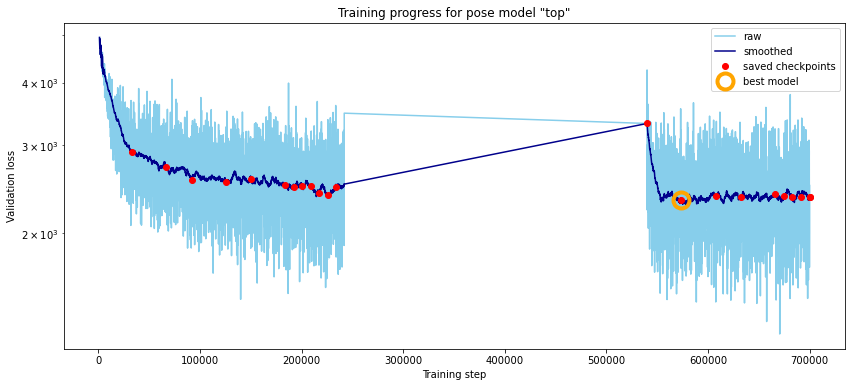

Saved best-performing checkpoint for model "top."


In [3]:
from hourglass_pose import evaluate_pose

# project_path = 'D:\my_project'
project_path = '/media/storage/sebastian/michael_data/tracking_example/'
evaluate_pose.plot_training_progress(project_path, omitFirst=1000, logTime=False)
evaluate_pose.save_best_checkpoint(project_path)

### 4.3 Evaluate model performance on a held-out test set

First, we'll run our selected model on the test set. `run_test` takes optional arguments:
* `pose_model_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [4]:
from hourglass_pose import evaluate_pose

# project_path = 'D:\my_project'
performance = evaluate_pose.run_test(project_path)

/media/storage/sebastian/michael_data/tracking_example/pose/top_model
is now:/media/storage/sebastian/michael_data/tracking_example/pose/top_model/model.ckpt-573620
INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/pose/top_model/model.ckpt-573620
Found model for global step: 573620
Step: 0, Time/image network (ms): 336.8
Step: 1, Time/image network (ms): 9.9
Step: 2, Time/image network (ms): 9.8
Step: 3, Time/image network (ms): 9.0
Step: 4, Time/image network (ms): 9.1
Step: 5, Time/image network (ms): 40.3
Step: 6, Time/image network (ms): 7.9
Step: 7, Time/image network (ms): 8.3
Step: 8, Time/image network (ms): 8.6
Step: 9, Time/image network (ms): 8.5
Step: 10, Time/image network (ms): 8.5
Step: 11, Time/image network (ms): 8.5
Step: 12, Time/image network (ms): 8.5
Step: 13, Time/image network (ms): 8.6
Step: 14, Time/image network (ms): 8.7
Step: 15, Time/image network (ms): 8.4
Step: 16, Time/image network (ms): 8.6
Step: 17, Tim

First, let's look at ground truth and predicted poses for a sample frame:

restoring 199 files from ['/media/storage/sebastian/michael_data/tracking_example/pose/top_tfrecords_pose/test_dataset-00000-of-00001']


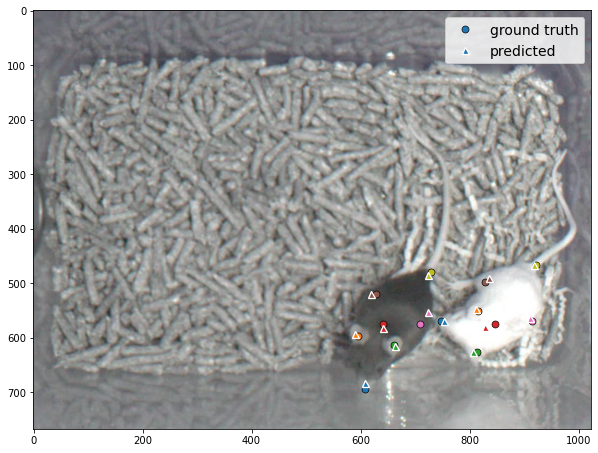

In [9]:
from hourglass_pose import evaluate_pose

# project_path = 'D:\my_project'
project_path = '/media/storage/sebastian/michael_data/tracking_example/'
frame_num = 100

evaluate_pose.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10])

Now let's get some summary statistics using the COCO API. First, the mean Average Precision and mean Average Recall (mAP and mAR) of the Object Keypoint Similarity (OKS) -- see our [notebook on pose evaluation](hourglass_pose/pose_evaluation_on_test_tfrecords.ipynb) for a tutorial on what these metrics mean.

In [10]:
performance = evaluate_pose.coco_eval(project_path)
performance['top']['all'].summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.519


By default, these values are computed using the "narrow" setting of the OKS, $\sigma = 0.025$. If you use the same keypoint names as MARS, you can also compute performance using keypoint-specific $\sigma$ values from the MARS pose datasets:

In [11]:
performance = evaluate_pose.coco_eval(project_path, view='top')
performance['top']['all'].summarize()

ValueError: Part not recognized. The valid part names for MARS_top keypoints are: nose tip | right ear | left ear | neck | right side body | left side body | tail base | middle tail | end tail

Finally, let's compare our PCK distribution from our model to what we got from our human annotators. `plot_model_PCK` takes similar arguments `plot_human_PCK`:
* `pose_model_names` specifies which models to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools human annotation data across animal types in your dataset. Model performance plots are always pooled (to be fixed later.)

/home/sebastianmap07/miniconda3/envs/mars_dev/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/sebastianmap07/MARS_Developer/pose_annotation_tools/evaluation.py:107: RuntimeWarning: Mean of empty slice
  dMean[:, fr] = np.nanmean(trial_dists, axis=0)


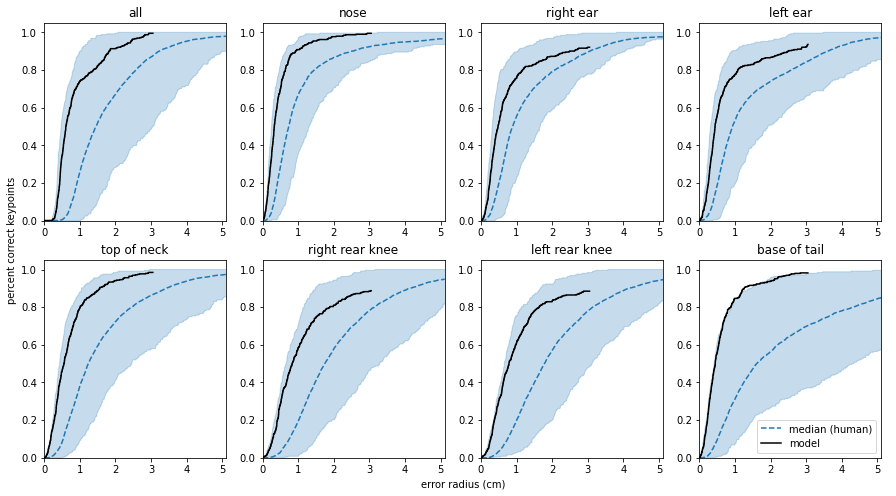

In [12]:
from hourglass_pose import evaluate_pose

# project_path = 'D:\my_project'
evaluate_pose.plot_model_PCK(project_path, combine_animals=True)

## 5. 🚀 Deploy your new detection and pose models

To use your trained models with the end-user version of MARS, we will export them as protobuf (`.pb`) files, which are saved to your main project folder.

`export` takes the optional arguments:
* `detector_names` specifies which detection models to save (defaults to all.)
* `pose_model_names` specifies which pose models to save (defaults to all.)


Copy the created files to your end-user version of MARS, in `mars_v1_8\models\detection` and `mars_v1_8\models\pose`. To run MARS using the new models, either modify the default settings in `mars_v1_8\config.yml`, or specify the model paths during runtime.

In [13]:
import export_models

# project_path = 'D:\my_project'
export_models.export(project_path)

INFO:tensorflow:Exporting model: /media/storage/sebastian/michael_data/tracking_example/detection/black_top_model/model.ckpt-376879
INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/detection/black_top_model/model.ckpt-376879
INFO:tensorflow:Froze 948 variables.
INFO:tensorflow:Converted 948 variables to const ops.
Saved optimized detection model at: /media/storage/sebastian/michael_data/tracking_example/tracking_example_black_top_detector.pb
Input node name: images
Output node names: predicted_locations:0 Multibox/Sigmoid:0
2206 ops in the final graph.
--
INFO:tensorflow:Exporting model: /media/storage/sebastian/michael_data/tracking_example/detection/white_top_model/model.ckpt-475868
INFO:tensorflow:Restoring parameters from /media/storage/sebastian/michael_data/tracking_example/detection/white_top_model/model.ckpt-475868
INFO:tensorflow:Froze 948 variables.
INFO:tensorflow:Converted 948 variables to const ops.
Saved optimized detection 